# Загрузка и предварительная обработка данных

Для начала загрузим данные и посмотрим на них:

In [1]:
from pandas import read_csv, DataFrame
import statsmodels as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import ml_metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import warnings
import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
dataset = pd.read_excel('C:/Users/DariaMishina/ML Daria/BST_DataSet.xlsx')

In [3]:
dataset.rename(columns={'Unnamed: 0': 'Дата'}, inplace=True)

In [4]:
dataset = dataset.set_index(pd.DatetimeIndex(dataset['Дата']))
dataset.drop(['Дата'], axis=1, inplace=True)

In [5]:
dataset.rename(columns={'Прирост вкладов физических лиц в рублях (млн руб)': 'target'}, inplace=True)

In [6]:
targ = dataset.target
targ.head()

Дата
2011-01-01    -79049.0
2011-02-01    180475.0
2011-03-01    106845.0
2011-04-01    224890.0
2011-05-01     45856.0
Name: target, dtype: float64

In [7]:
targ = targ[:72]

В итоге получили временной ряд, проанализируем его

# Анализ временного ряда

Построим график

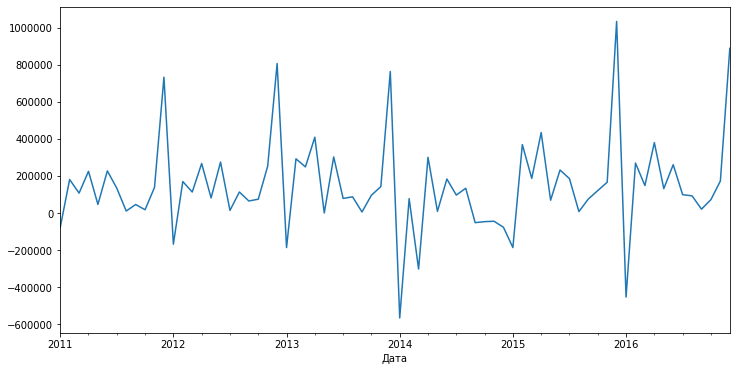

In [8]:
targ.plot(figsize=(12,6))

Судя по виду графика, ряд не является стационарным.

count    7.200000e+01
mean     1.466405e+05
std      2.593857e+05
min     -5.674480e+05
25%      1.949025e+04
50%      1.129245e+05
75%      2.360528e+05
max      1.034556e+06
Name: target, dtype: float64

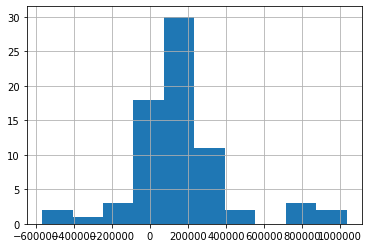

In [9]:
itog = targ.describe()
targ.hist()
itog

Исходя из характеристик и гистограммы, ряд у нас более менее однородный и имеет относительно небольшой разброс 

In [11]:
test = sm.tsa.adfuller(targ)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -1.5624513827398336
p-value:  0.5024228765613985
Critical values:  {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}
есть единичные корни, ряд не стационарен


Проведенный тест подтвердил предположения о не стационарности ряда. Попробуем взять разность рядов

In [12]:
targ1diff = targ.diff(periods=1).dropna()

Проверим получившийся ряд на стационарность:

In [13]:
test = sm.tsa.adfuller(targ1diff)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -3.13889800931166
p-value:  0.02380530677860101
Critical values:  {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}
единичных корней нет, ряд стационарен


Осталось убедиться в отсутствии тренда для этого построим график нашего нового ряда:

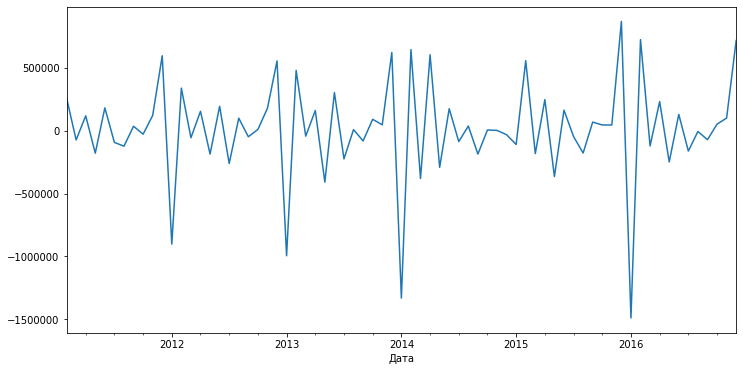

In [14]:
targ1diff.plot(figsize=(12,6))

Тренд отсутствует, то есть, ряд первых разностей является стационарным, а исходный ряд — интегрированным рядом первого порядка.

# Построение модели временного ряда

In [15]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


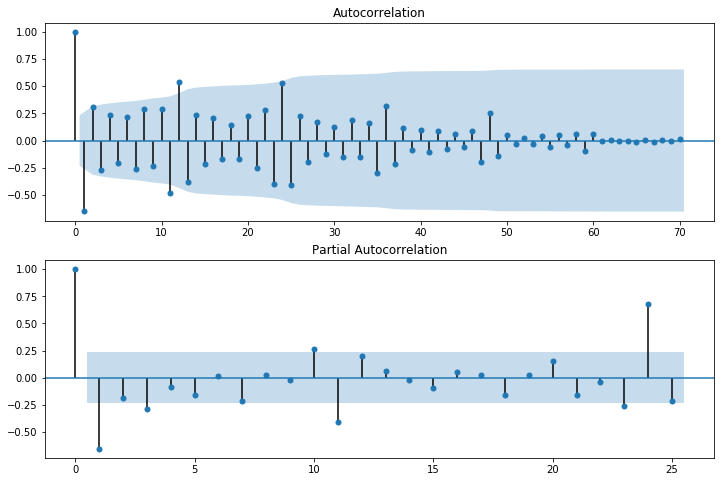

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(targ1diff.values.squeeze(), lags=70, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(targ1diff, lags=25, ax=ax2)

После изучения коррелограммы PACF можно сделать вывод, что p = 4, т.к. на ней только 4 лага сильно отличны от нуля. По коррелограмме ACF можно увидеть, что q = 2, т.к. после лага 2 значении функций падают.
Итак, когда известны все параметры можно построить модель, но мы возьмем значение p=4 и q=2 за начальное приближение, d=1 (так как у нас интегрированный ряд 1го порядка), а дальше переберем  все модели ARIMA(p,d,q) со значениями p=0..4, q=0..2 и найдем наилучшего кандидата по разным статистическим критериям

In [17]:
p = range(0, 5)
d = range(0, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
print('Examples of parameter combinations for ARIMA...')
print('ARIMA: {}'.format(pdq[1]))
print('ARIMA: {}'.format(pdq[2]))
print('ARIMA: {}'.format(pdq[3]))

Examples of parameter combinations for ARIMA...
ARIMA: (0, 0, 1)
ARIMA: (0, 0, 2)
ARIMA: (0, 1, 0)


In [18]:
warnings.filterwarnings("ignore")  
for param in pdq:
    try:
        mod=sm.tsa.ARIMA(targ, order=param)
        results = mod.fit(transparams=True)
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

ARIMA(0, 0, 0) - AIC:2002.4344207451177
ARIMA(0, 0, 1) - AIC:1998.3020592211537
ARIMA(0, 0, 2) - AIC:2000.18131852625
ARIMA(0, 1, 0) - AIC:2038.7931230509196
ARIMA(0, 1, 1) - AIC:1981.545604145638
ARIMA(0, 1, 2) - AIC:1978.1944859469013
ARIMA(1, 0, 0) - AIC:1997.7334732720071
ARIMA(1, 0, 1) - AIC:2007.2485022038672
ARIMA(1, 1, 0) - AIC:2000.6150136179774
ARIMA(1, 1, 1) - AIC:1977.47585468184
ARIMA(2, 0, 0) - AIC:1999.580865039156
ARIMA(2, 0, 2) - AIC:2007.9509565747667
ARIMA(2, 1, 0) - AIC:1998.5121557674431
ARIMA(2, 1, 1) - AIC:1979.197262588613
ARIMA(3, 0, 0) - AIC:1999.4468487396093
ARIMA(3, 0, 1) - AIC:1993.3639530902894
ARIMA(3, 1, 0) - AIC:1991.554527047299
ARIMA(3, 1, 1) - AIC:1979.4133010892679
ARIMA(4, 0, 0) - AIC:2001.3603150687366
ARIMA(4, 1, 0) - AIC:1991.0614479851358
ARIMA(4, 1, 1) - AIC:1981.2461990425024


самый лучший (1, 1, 1) 1977.4758546818

Итак, когда известны все параметры можно построить модель, но для ее построения мы возмем не все данные, а только часть - до 2016 г. Данные из части не попавших в модель мы оставим для проверки точности прогноза нашей модели:

In [81]:
src_data_model = targ[:'2015-12-01']
model = sm.tsa.ARIMA(src_data_model, order=(1,1,1)).fit(full_output=False, disp=0)

In [82]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Otgruzka   No. Observations:                   59
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -818.207
Method:                       css-mle   S.D. of innovations         245289.937
Date:                Sat, 06 Jun 2020   AIC                           1644.413
Time:                        22:57:39   BIC                           1652.723
Sample:                    02-01-2011   HQIC                          1647.657
                         - 12-01-2015                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              324.2092   1501.068      0.216      0.829   -2617.830    3266.248
ar.L1.D.Otgruzka    -0.2390      0.144     -1.660      0.097      -0.521       0.043
ma.L1.D.Otgruzka    -1.0000 

# Анализ и оценка модели

Оценим остатки данной модели на соответствие «белому шуму», а также проанализируем коррелограму остатков

In [83]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True)  
print(DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    0.021713  0.882852
1    0.295036  0.862847
2    1.578468  0.664282
3    1.809533  0.770738
4    2.000691  0.849049
5    2.853885  0.826950
6    3.030623  0.882155
7    7.211699  0.513974
8    7.222928  0.613922
9    8.217290  0.607622
10  10.571500  0.479827
11  15.517536  0.214346
12  22.239784  0.051756
13  22.948904  0.061106
14  25.550621  0.043020
15  26.272679  0.050310
16  26.604720  0.064125
17  26.799961  0.082825
18  27.321060  0.097394
19  27.393992  0.124539
20  32.961055  0.046651
21  33.577188  0.054203
22  38.337490  0.023427
23  49.394552  0.001690
24  51.331901  0.001455
25  51.337066  0.002169
26  52.573165  0.002265
27  52.922270  0.002998
28  52.934315  0.004281
29  53.025462  0.005892
30  53.610282  0.007078
31  54.063341  0.008710
32  54.437727  0.010825
33  54.469575  0.014405
34  56.924276  0.011006
35  60.056758  0.007174
36  60.682721  0.008355
37  60.740149  0.010986
38  60.747972  0.014428
39  61.013375  0.017743


Значение данной статистики и p-values, свидетельствуют о том, что гипотеза о случайности остатков не отвергается, и скорее всего данный процесс представляет «белый шум».

Сразу же делаем предсказание на 2017 г

In [118]:
pred1 = model.predict('2015-12-01','2018-01-01', typ='levels')

RMSE нашей модели:

In [106]:
metrics.rmse(trn,pred[1:14])

423309.9698260289

MAE для модели:

In [107]:
metrics.mae(trn,pred[1:14])

256476.45662910046

Выведем прогноз c помощью графика

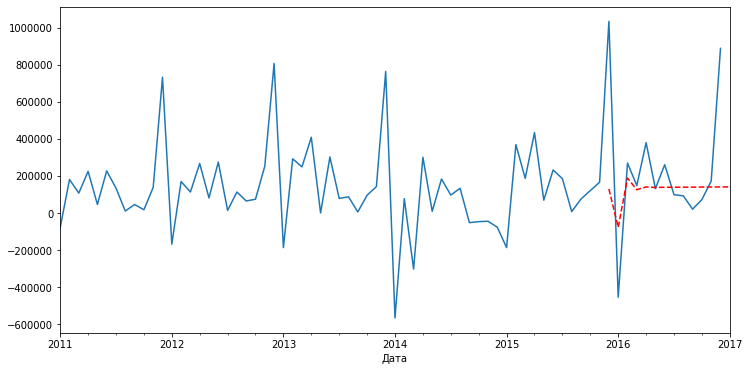

In [108]:
targ.plot(figsize=(12,6))
pred.plot(style='r--')

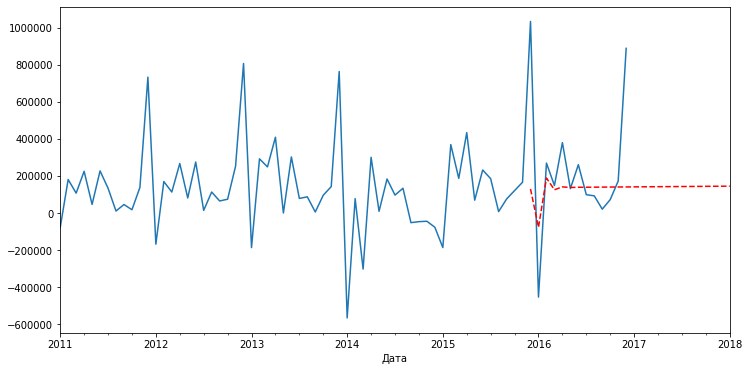

In [119]:
targ.plot(figsize=(12,6))
pred1.plot(style='r--')

# Вывод

Судя по графику, ARIMA не подходит для построения прогноза, нужно пробовать SARIMA